In [2]:
# inport statements

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsRegressor as KNR
from xgboost import XGBRegressor as XGBR # conda install -c conda-forge xgboost
                                         #  pip install xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [3]:
# uncomment lines below to generate labeled_data.csv and unlabeled_data.csv files

# data = pd.read_csv('elasticsearch-seed.csv')

# features_name = ['BathsTotal', 'BedsTotal', 'CDOM', 'LotSizeAreaSQFT', 'SqFtTotal', 'ElementarySchoolName']
# target_name = 'ClosePrice'

# labeled_data = data.loc[~data['ClosePrice'].isna()]
# unlabeled_data = data.loc[data['ClosePrice'].isna()].drop(columns='ClosePrice')
# labeled_data = labeled_data[features_name + [target_name]]
# unlabeled_data = unlabeled_data[features_name]

# labeled_data.to_csv('labeled_data.csv', index=False)
# unlabeled_data.to_csv('unlabeled_data.csv', index=False)

In [4]:
# read data
labeled_data = pd.read_csv('labeled_data.csv')
unlabeled_data = pd.read_csv('unlabeled_data.csv')

print(f'labeled data shape {labeled_data.shape}')
print(f'unlabeled data shape {unlabeled_data.shape}')

labeled data shape (223, 7)
unlabeled data shape (430, 6)


In [5]:
# We want to group ElementarySchoolName values regarding the mean ClosePrice
def get_school_group(price):
    if np.isnan(price):
        group = 5
    else:
        group = min(max((price // 100000) - 2, 0), 4)
    return f'group_{group:.0f}'

data = pd.concat((labeled_data, unlabeled_data), axis=0)
price_per_school = data[['ElementarySchoolName', 'ClosePrice']].groupby(by='ElementarySchoolName').mean().reset_index()
price_per_school['group'] = price_per_school['ClosePrice'].map(get_school_group)
schools_groups_map = dict(price_per_school[['ElementarySchoolName', 'group']].to_numpy())

In [6]:
labeled_data['ElementarySchoolName'] = labeled_data['ElementarySchoolName'].map(lambda x: schools_groups_map[x])
unlabeled_data['ElementarySchoolName'] = unlabeled_data['ElementarySchoolName'].map(lambda x: schools_groups_map[x])

In [7]:
labeled_data

,BathsTotal,BedsTotal,CDOM,LotSizeAreaSQFT,SqFtTotal,ElementarySchoolName,ClosePrice
0,3.0,4,52,7100.28,2484,group_2,485000.0
1,2.1,4,58,8712.00,2631,group_1,330000.0
2,1.1,1,38,1306.80,884,group_1,185000.0
3,2.0,3,11,6969.60,1451,group_0,210000.0
4,2.0,3,89,6098.40,1559,group_1,225000.0
...,...,...,...,...,...,...,...
218,4.1,4,39,12153.24,4758,group_2,950000.0
219,4.1,4,58,16465.68,4140,group_4,970000.0
220,4.2,5,166,11717.64,7891,group_2,1225000.0
221,4.1,5,16,23565.96,5805,group_4,1485000.0


In [8]:
target_name = 'ClosePrice'

# get each columns by type
categorical_features = unlabeled_data.select_dtypes('object').columns
numerical_features = unlabeled_data.select_dtypes(['int64', 'float64']).columns

In [9]:
data = pd.concat((labeled_data[unlabeled_data.columns], unlabeled_data), axis=0)

# dummy categorical features
data = pd.get_dummies(data, drop_first=True)
labeled_data = pd.concat((data.iloc[:labeled_data.shape[0],:], labeled_data[target_name]), axis=1)
unlabeled_data = data.iloc[labeled_data.shape[0]:,:]

# scale numerical features
scaler = MinMaxScaler()
scaler.fit(data[numerical_features])
labeled_data[numerical_features] = scaler.transform(labeled_data[numerical_features])
unlabeled_data[numerical_features] = scaler.transform(unlabeled_data[numerical_features])

In [10]:
labels = labeled_data['ClosePrice'].to_numpy()
features = labeled_data.drop(columns='ClosePrice').to_numpy()

In [11]:
def plot_predictions_vs_actual(labels, predictions):
    plt.scatter(labels, predictions)
    plt.xlabel('true prices')
    plt.ylabel('predicted prices')
    plt.title('true prices vs predicted prices')

# Random Forest

In [12]:
# cross validation and model fitting
rf = RF()
rf.fit(features, labels)
rf.score(features, labels)

0.9770520221592477

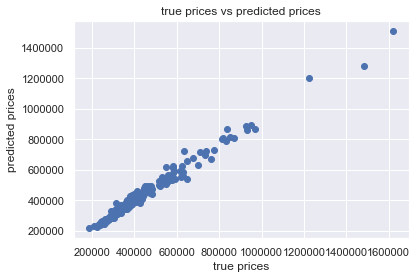

In [13]:
plot_predictions_vs_actual(labels, rf.predict(features))
plt.savefig('random_forest.png')

# Linear regression

In [14]:
# cross validation and model fitting
lr = LR()
lr.fit(features, labels)
lr.score(features, labels)

0.8170382695843789

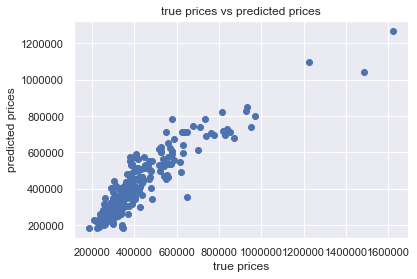

In [15]:
plot_predictions_vs_actual(labels, lr.predict(features))
plt.savefig('linear_regression.png')

# KNeighbors Regressor

In [16]:
#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

#### Create train and test split

In [17]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(labeled_data, test_size = 0.3)

x_train = train.drop('ClosePrice', axis=1)
y_train = train['ClosePrice']

x_test = test.drop('ClosePrice', axis = 1)
y_test = test['ClosePrice']

#### Preprocessing – Scaling the features

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

#### Let us have a look at the error rate for different k values

In [19]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 169896.05883374342
RMSE value for k=  2 is: 164924.66724514452
RMSE value for k=  3 is: 161472.51078303426
RMSE value for k=  4 is: 162221.16568504705
RMSE value for k=  5 is: 160815.06863454598
RMSE value for k=  6 is: 161230.48812467838
RMSE value for k=  7 is: 163633.68966547787
RMSE value for k=  8 is: 165498.30232135666
RMSE value for k=  9 is: 166091.40758612668
RMSE value for k=  10 is: 168811.2217050556
RMSE value for k=  11 is: 168373.31577473693
RMSE value for k=  12 is: 164047.16468195146
RMSE value for k=  13 is: 166210.50514547597
RMSE value for k=  14 is: 168595.81913614838
RMSE value for k=  15 is: 171609.81023683093
RMSE value for k=  16 is: 172838.50828343225
RMSE value for k=  17 is: 174005.87307375754
RMSE value for k=  18 is: 175169.7206306825
RMSE value for k=  19 is: 176154.49810039302
RMSE value for k=  20 is: 180100.10293175798


#### Plotting the rmse values against k values

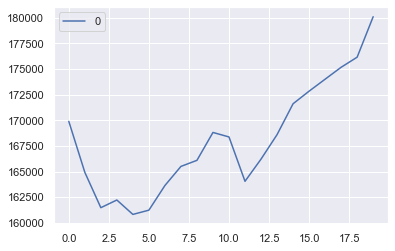

In [20]:

curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

# At k= 2, the RMSE is at it's lowest, and shoots up on further increasing the k value. 
#We can safely say that k=7 will give us the best result in this case.

In [21]:
# cross validation and model fitting
knr = KNR()
knr.fit(features, labels)
knr.score(features, labels)

0.8371431740319235

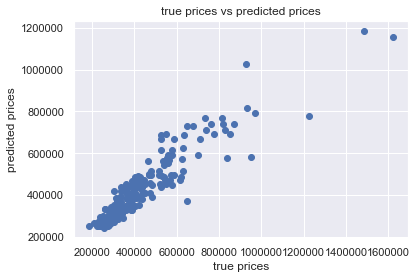

In [22]:
plot_predictions_vs_actual(labels, knr.predict(features))
plt.savefig('kneighbors.png')

# Gradient Boosted Trees Regressor

In [23]:
# cross validation and model fitting
xgbr = XGBR()
xgbr.fit(features, labels)
xgbr.score(features, labels)

[16:47:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9751418878657215

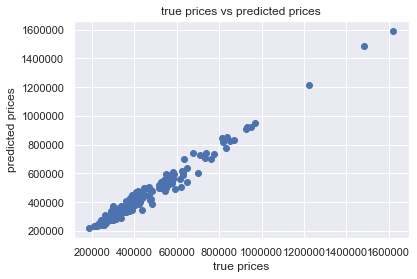

In [24]:
plot_predictions_vs_actual(labels, xgbr.predict(features))
plt.savefig('xgb.png')

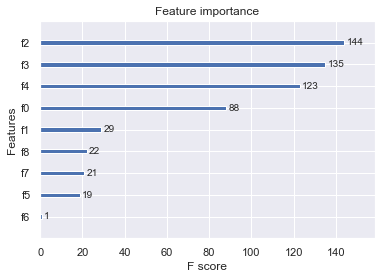

In [25]:
import xgboost as xgb
xgb.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [26]:
# save predictions on unlabeled data

unlabeled_data_predictions = unlabeled_data.copy()
unlabeled_data_predictions['ClosePrice'] = xgbr.predict(unlabeled_data.to_numpy())
unlabeled_data_predictions.to_csv('unlabeled_data_predictions.csv', index=False)

In [27]:
# Numpy and pandas as usual
import numpy as np
import pandas as pd

# Scikit-Learn for fitting models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# For plotting in the notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Default parameters for plots
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.titlesize'] = 16
matplotlib.rcParams['figure.figsize'] = [9, 7]

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

# Cross Validation with k-folds

In [29]:
 from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # import KFold

In [30]:
X = features 
Y = labels



In [32]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.metrics import accuracy_score as accuracy, accuracy_score

kf = KFold(n_splits=5,random_state=42,shuffle=True)



# these are you training data points:
# features and targets

y = labels #features

accuracies = []

for train_index, test_index in kf.split(X):

    data_train   = X[train_index]
    target_train = y[train_index]

    data_test    = X[test_index]
    target_test  = y[test_index]

    

    clf = LogisticRegression()
    clf.fit(data_train,target_train)

    test_preds = clf.predict(data_test)
    test_accuracy = accuracy_score(target_test,test_preds)

    train_preds = clf.predict(data_train)
    train_accuracy = accuracy_score(target_train, train_preds)

    print(train_accuracy, test_accuracy, (train_accuracy - test_accuracy) )

    #accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

0.06741573033707865 0.0 0.06741573033707865
0.07865168539325842 0.0 0.07865168539325842
0.05056179775280899 0.0 0.05056179775280899
0.05027932960893855 0.0 0.05027932960893855
0.05027932960893855 0.0 0.05027932960893855


### XGBoost Cross-val

In [33]:

# fit model no training data
model = XGBR ()
model.fit(data_train, target_train)

[16:51:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [34]:

# make predictions for test data
target_test = model.predict(data_test)

predictions = [round(value) for value in target_test]

In [39]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

r_square = np.sqrt(r2_score(target_test, predictions))
print("R-Squared: %f" % (r_square))

rmse = np.sqrt(mean_squared_error(target_test, predictions))
print("RMSE: %f" % (rmse))

mae = np.sqrt(mae(target_test, predictions))
print("MAE: %f" % (mae))

R-Squared: 1.000000
RMSE: 0.296164
MAE: 0.509846


### KN Regressor Cross Val

In [53]:
modelKNR = KNR()
modelKNR.fit(data_train, target_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [54]:
# make predictions for test data
target_test = modelKNR.predict(data_test)

predictions = [round(value) for value in target_test]

In [55]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

r_square = np.sqrt(r2_score(target_test, predictions))
print("R-Squared: %f" % (r_square))

rmse = np.sqrt(mean_squared_error(target_test, predictions))
print("RMSE: %f" % (rmse))

mae = np.sqrt(mae(target_test, predictions))
print("MAE: %f" % (mae))

R-Squared: 1.000000
RMSE: 0.000000
MAE: 0.000000


### Linear regression K-Folds

In [43]:
modelLR = LR()
modelLR.fit(data_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
# make predictions for test data
target_test = modelLR.predict(data_test)

predictions = [round(value) for value in target_test]

In [45]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

r_square = np.sqrt(r2_score(target_test, predictions))
print("R-Squared: %f" % (r_square))

rmse = np.sqrt(mean_squared_error(target_test, predictions))
print("RMSE: %f" % (rmse))

mae = np.sqrt(mae(target_test, predictions))
print("MAE: %f" % (mae))

R-Squared: 1.000000
RMSE: 0.262281
MAE: 0.484805


### Random Forest K-Folds

In [46]:
modelRF = RF()
modelRF.fit(data_train, target_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [47]:
# make predictions for test data
target_test = modelRF.predict(data_test)

predictions = [round(value) for value in target_test]

In [48]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

r_square = np.sqrt(r2_score(target_test, predictions))
print("R-Squared: %f" % (r_square))

rmse = np.sqrt(mean_squared_error(target_test, predictions))
print("RMSE: %f" % (rmse))

mae = np.sqrt(mae(target_test, predictions))
print("MAE: %f" % (mae))

R-Squared: 1.000000
RMSE: 0.239692
MAE: 0.408155
